# Do Different Factors Affect Video Game Sales in Different Regions?

## Thesis Statement

The goal of this project is to investigate whether specific features of a video game — such as its publisher, platform, genre, critic score, or user score — are strongly correlated with its sales performance in different regions. I hypothesize that different markets (North America, Europe, and Japan) emphasize different factors when purchasing games. For example, Nintendo-published titles may perform better in Japan, while highly rated games may drive more sales in North America.

## Plan for Analysis

To test this hypothesis, I will:
- Analyze the correlation between various game attributes and regional sales (`NA_Sales`, `EU_Sales`, `JP_Sales`).
- Use regression models to quantify the strength of influence each feature has on sales.
- Compare and interpret the results across regions to identify patterns or regional preferences.

The outcome of this analysis will reveal whether certain attributes have a consistent or region-specific effect on sales, and how strongly internal features alone can explain commercial success.

## Data Source

The data used in this project comes from the Kaggle dataset:
- URL: https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
- Citation: Rush Kirubi. (2017). *Video Game Sales with Ratings*. Kaggle.


# Imports

We begin by importing the necessary packages.

In [174]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten


# The Data

This is a visual depiction of the data we will be working with in this analysis.

In [175]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the Data

Observing our dataframe, we find that some columns have many null values. To make the data more useable, we drop unnecessary columns, and replace null values so that they can be encoded properly. Note that we chose to drop Critic and User score, since populating them with -1 would be misleading.

In [176]:
# Drop rows where Critic_Score or User_Score is missing originally
df_mod = df.dropna(subset=['Critic_Score', 'User_Score']).copy()

# Fill missing for categorical columns
for col in ['Publisher', 'Developer', 'Rating']:
    df_mod[col] = df_mod[col].fillna('Unknown')

# Fill missing numerical year with -1
df_mod['Year_of_Release'] = df_mod['Year_of_Release'].fillna(-1)

# Now fix User_Score properly
df_mod['User_Score'] = pd.to_numeric(df_mod['User_Score'], errors='coerce')

# Drop rows where User_Score is NaN AFTER conversion (important!)
df_mod = df_mod.dropna(subset=['User_Score'])

# Drop extra columns not needed
df_mod = df_mod.drop(['Critic_Count', 'User_Count'], axis=1)

# Final missing check
print(df_mod.isnull().sum())

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
User_Score         0
Developer          0
Rating             0
dtype: int64


# Encoding

Once we have cleaned our data up, we set up our different target variables (one for each sales region in the dataframe) and encode the data so that we can perform a linear regression.

In [177]:
# Setup targets
y_na = df_mod['NA_Sales']
y_eu = df_mod['EU_Sales']
y_jp = df_mod['JP_Sales']
y_oth = df_mod['Other_Sales']
y_global = df_mod['Global_Sales']

# Set categorical features
cat_features = ['Platform', 'Genre', 'Publisher', 'Rating']

# OneHotEncoder with dense output
oneHotEnc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# ColumnTransformer
coltrans = ColumnTransformer(
    transformers=[
        ("onehot", oneHotEnc, cat_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Drop unnecessary columns
X_features = df_mod.drop(
    ['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Developer', 'Year_of_Release'],
    axis=1
)

# Transform
X_trans = coltrans.fit_transform(X_features)


# Splitting the Data

We begin our analysis by creating the train and test sets for each prediction we want to make (NA, EU, JP, Other, and Global).

In [178]:
from sklearn.model_selection import train_test_split

# Split features and target (for NA_Sales first)
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X_trans, y_na, test_size=0.2, random_state=42)

# Split features and target (for EU_Sales second)
X_train_eu, X_test_eu, y_train_eu, y_test_eu = train_test_split(X_trans, y_eu, test_size=0.2, random_state=42)

# Split features and target (for JP_Sales third)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X_trans, y_jp, test_size=0.2, random_state=42)

# Split features and target (for Other_Sales fourth)
X_train_oth, X_test_oth, y_train_oth, y_test_oth = train_test_split(X_trans, y_oth, test_size=0.2, random_state=42)

# Split features and target (for Global_Sales last)
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X_trans, y_global, test_size=0.2, random_state=42)


# Making Predictions

Once we have set up our training and testing data, we fit a linear regression model for each target.

In [179]:
# Instantiate model
linreg_na = LinearRegression()
linreg_eu = LinearRegression()
linreg_jp = LinearRegression()
linreg_oth = LinearRegression()
linreg_global = LinearRegression()

# Train (fit) on training data
linreg_na.fit(X_train_na, y_train_na)
linreg_eu.fit(X_train_eu, y_train_eu)
linreg_jp.fit(X_train_jp, y_train_jp)
linreg_oth.fit(X_train_oth, y_train_oth)
linreg_global.fit(X_train_global, y_train_global)

# Predict on test data
y_pred_na = linreg_na.predict(X_test_na)
y_pred_eu = linreg_eu.predict(X_test_eu)
y_pred_jp = linreg_jp.predict(X_test_jp)
y_pred_oth = linreg_oth.predict(X_test_oth)
y_pred_global = linreg_global.predict(X_test_global)

# Evaluate performance
from sklearn.metrics import r2_score, mean_squared_error

# For North America Sales
print("Linear Regression Results (North America):")
print("R² Score:", r2_score(y_test_na, y_pred_na))
print("MSE:", mean_squared_error(y_test_na, y_pred_na))

# For European Sales
print("\nLinear Regression Results (Europe):")
print("R² Score:", r2_score(y_test_eu, y_pred_eu))
print("MSE:", mean_squared_error(y_test_eu, y_pred_eu))

# For Japanese Sales
print("\nLinear Regression Results (Japan):")
print("R² Score:", r2_score(y_test_jp, y_pred_jp))
print("MSE:", mean_squared_error(y_test_jp, y_pred_jp))

# For Other Sales
print("\nLinear Regression Results (Other):")
print("R² Score:", r2_score(y_test_oth, y_pred_oth))
print("MSE:", mean_squared_error(y_test_oth, y_pred_oth))

# For Global Sales
print("\nLinear Regression Results (Global):")
print("R² Score:", r2_score(y_test_global, y_pred_global))
print("MSE:", mean_squared_error(y_test_global, y_pred_global))





Linear Regression Results (North America):
R² Score: 0.18406280880477388
MSE: 0.5896417278191177

Linear Regression Results (Europe):
R² Score: 0.1598666290001861
MSE: 0.25128502444810397

Linear Regression Results (Japan):
R² Score: 0.185306955161744
MSE: 0.039843088498274726

Linear Regression Results (Other):
R² Score: 0.18463292932996422
MSE: 0.030766418028379018

Linear Regression Results (Global):
R² Score: 0.1872528927312227
MSE: 1.9758737133140583


# Results of the Linear Regression

As shown above, it is clear that the data provided to us does not fully account for video game sales across the world. Most of the predictions had an R^2 score of about 0.18, meaning the factors we were given seem to play a role in video game sales, but there are other aspects that could also affect it. This makes sense in a real world context! After all, aspects like advertising, franchise, and time of year all affect sales as well. We can do a little more digging, though, so next we do a Lasso Regression.

In [180]:
# Instantiate LassoCV models
lasso_na = LassoCV(cv=5, random_state=42)
lasso_eu = LassoCV(cv=5, random_state=42)
lasso_jp = LassoCV(cv=5, random_state=42)
lasso_oth = LassoCV(cv=5, random_state=42)
lasso_global = LassoCV(cv=5, random_state=42)

# Train on training data
lasso_na.fit(X_train_na, y_train_na)
lasso_eu.fit(X_train_eu, y_train_eu)
lasso_jp.fit(X_train_jp, y_train_jp)
lasso_oth.fit(X_train_oth, y_train_oth)
lasso_global.fit(X_train_global, y_train_global)

# Predict on test data
y_pred_lasso_na = lasso_na.predict(X_test_na)
y_pred_lasso_eu = lasso_eu.predict(X_test_eu)
y_pred_lasso_jp = lasso_jp.predict(X_test_jp)
y_pred_lasso_oth = lasso_oth.predict(X_test_oth)
y_pred_lasso_global = lasso_global.predict(X_test_global)

# Evaluate Lasso
print("Lasso Regression Results (North America):")
print("Best alpha:", lasso_na.alpha_)
print("R² Score:", r2_score(y_test_na, y_pred_lasso_na))
print("MSE:", mean_squared_error(y_test_na, y_pred_lasso_na))

print("\nLasso Regression Results (Europe):")
print("Best alpha:", lasso_eu.alpha_)
print("R² Score:", r2_score(y_test_eu, y_pred_lasso_eu))
print("MSE:", mean_squared_error(y_test_eu, y_pred_lasso_eu))

print("\nLasso Regression Results (Japan):")
print("Best alpha:", lasso_jp.alpha_)
print("R² Score:", r2_score(y_test_jp, y_pred_lasso_jp))
print("MSE:", mean_squared_error(y_test_jp, y_pred_lasso_jp))

print("\nLasso Regression Results (Other):")
print("Best alpha:", lasso_oth.alpha_)
print("R² Score:", r2_score(y_test_oth, y_pred_lasso_oth))
print("MSE:", mean_squared_error(y_test_oth, y_pred_lasso_oth))

print("\nLasso Regression Results (Global):")
print("Best alpha:", lasso_global.alpha_)
print("R² Score:", r2_score(y_test_global, y_pred_lasso_global))
print("MSE:", mean_squared_error(y_test_global, y_pred_lasso_global))



Lasso Regression Results (North America):
Best alpha: 0.003004391829001223
R² Score: 0.1707240692018237
MSE: 0.5992810450990319

Lasso Regression Results (Europe):
Best alpha: 0.0019427802117764517
R² Score: 0.15315309138857047
MSE: 0.25329305260303897

Lasso Regression Results (Japan):
Best alpha: 0.0006068229190025472
R² Score: 0.21535607550921698
MSE: 0.03837351689841239

Lasso Regression Results (Other):
Best alpha: 0.0006997323871066279
R² Score: 0.17765788849049047
MSE: 0.03102960871874614

Lasso Regression Results (Global):
Best alpha: 0.00625252112398844
R² Score: 0.17686639932891257
MSE: 2.0011243713645057


# Results of Lasso Regression

Lasso Regression gives us similar results as Linear Regression, with very low "best alpha values." One thing that was not mentioned in the Linear Regression analysis is the MSE values, which tell us how close our model is getting to predicting the actual values.

As shown above, MSE was relatively high for NA, at about 0.6. Europe was slightly lower at about 0.25. Japan and other regions were very low, at 0.03. Lastly, the MSE for the Global prediction was WAY high at about 2! This shows that some of the predictions were actually quite close, despite the low R^2 values, but some, such as global, were really off.

Lastly, we wish to answer the question we posed in the beginning as best as possible: Do certain factors affect sales differently in different regions. We'll analyze each region separately.

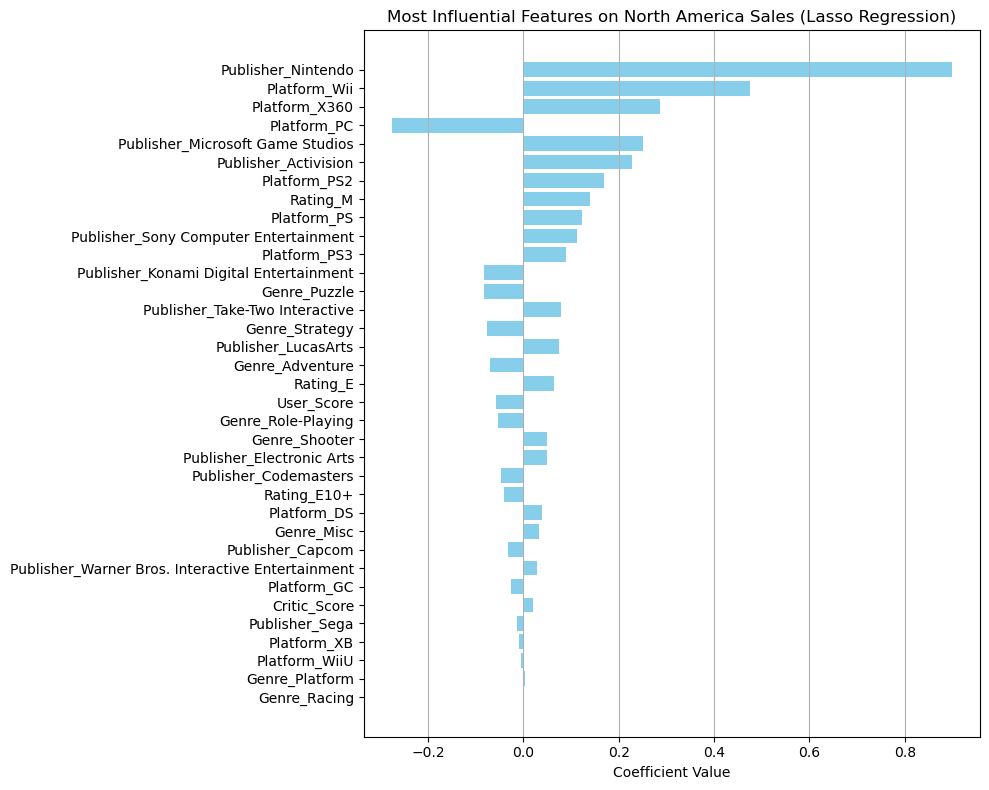

In [181]:
# 1. Get feature names after transformation
feature_names = coltrans.get_feature_names_out()

# 2. Get the coefficients from the Lasso model
coefficients = lasso_na.coef_

# 3. Combine into a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Filter only important (nonzero) features
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# 5. Sort by absolute value of coefficient (biggest influence first)
important_features = important_features.reindex(important_features['Coefficient'].abs().sort_values(ascending=True).index)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.barh(important_features['Feature'], important_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Most Influential Features on North America Sales (Lasso Regression)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# Most Influential Features in North America

The seeming most important feature in determining a game's sales seems to be its publisher. Specifically, it seems that a game being published by Nintendo correlates with higher sales. The second and third highest are the Wii Platform, followed by XBox 360 platform. The former agrees with Nintendo being on top and the latter shows that XBox 360 games also sold very well.

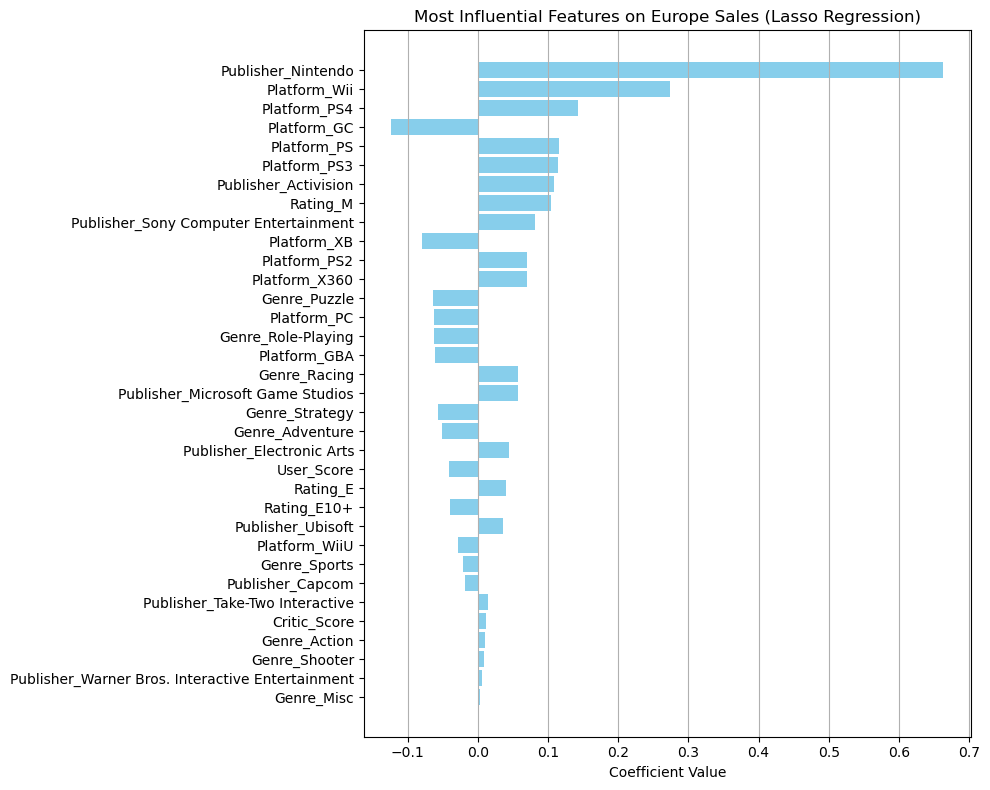

In [182]:
# 1. Get feature names after transformation
feature_names = coltrans.get_feature_names_out()

# 2. Get the coefficients from the Lasso model
coefficients = lasso_eu.coef_

# 3. Combine into a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Filter only important (nonzero) features
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# 5. Sort by absolute value of coefficient (biggest influence first)
important_features = important_features.reindex(important_features['Coefficient'].abs().sort_values(ascending=True).index)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.barh(important_features['Feature'], important_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Most Influential Features on Europe Sales (Lasso Regression)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# Most Influential Features in Europe

Much like in North America, the publisher being Nintendo seems to be correlated with high sales. Wii is also the second most influential feature, followed this time by PS4, suggesting that PS4 games sold better in Europe than in North American, which saw XBox 360 games selling better.

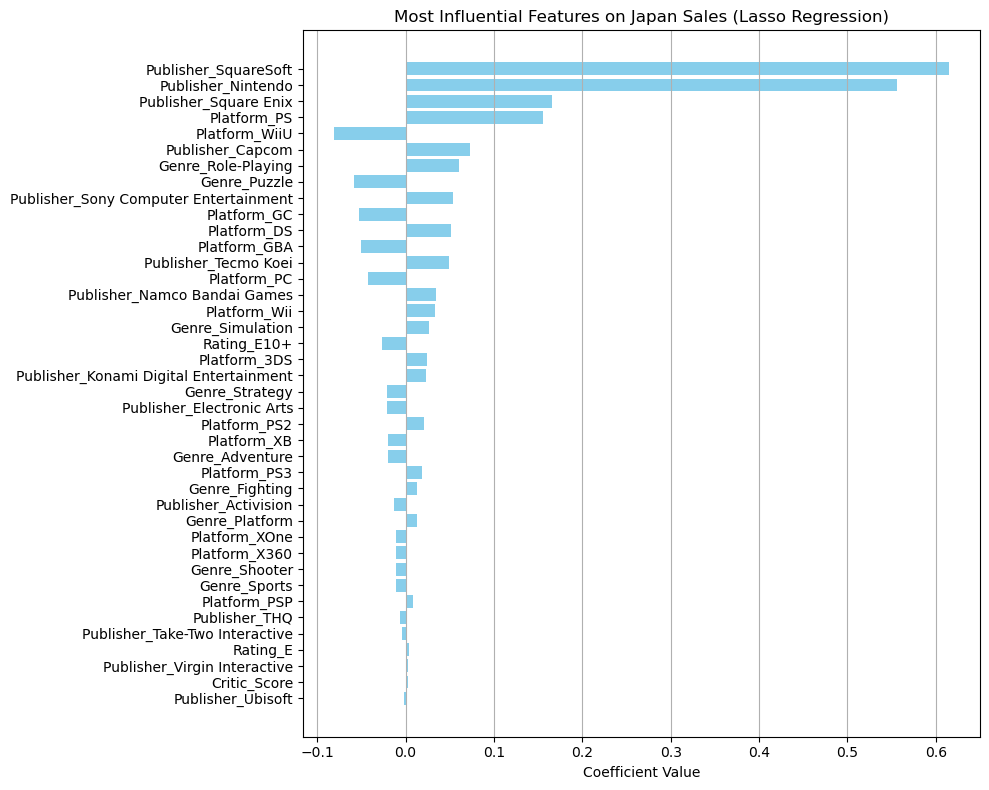

In [183]:
# 1. Get feature names after transformation
feature_names = coltrans.get_feature_names_out()

# 2. Get the coefficients from the Lasso model
coefficients = lasso_jp.coef_

# 3. Combine into a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Filter only important (nonzero) features
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# 5. Sort by absolute value of coefficient (biggest influence first)
important_features = important_features.reindex(important_features['Coefficient'].abs().sort_values(ascending=True).index)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.barh(important_features['Feature'], important_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Most Influential Features on Japan Sales (Lasso Regression)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# Most Influential Features in Japan

This was probably the most surprising finding. While Nintendo seems to dominate both North America and Europe, SquareSoft seems to be the best selling publisher in Japan, despite Nintendo being a company based out of Japan. A bit of research shows that SquareSoft originated in Tokyo, but has since relocated to the US. Nonetheless, it still seems to sell very well in Japan. That being said, Nintendo is very close to it as the second most influential seller, followed by Square Enix. This is interesting, since there are no platforms in the top 3. This suggests that publisher has a stronger influence in the Japanese Market.

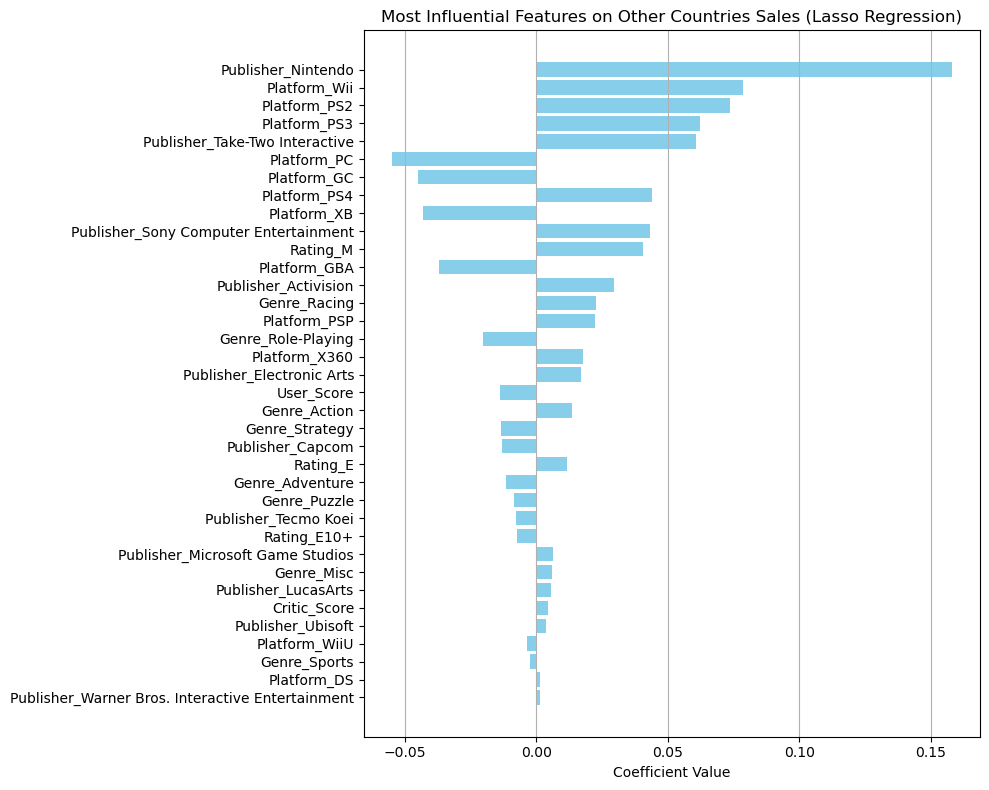

In [184]:
# 1. Get feature names after transformation
feature_names = coltrans.get_feature_names_out()

# 2. Get the coefficients from the Lasso model
coefficients = lasso_oth.coef_

# 3. Combine into a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Filter only important (nonzero) features
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# 5. Sort by absolute value of coefficient (biggest influence first)
important_features = important_features.reindex(important_features['Coefficient'].abs().sort_values(ascending=True).index)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.barh(important_features['Feature'], important_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Most Influential Features on Other Countries Sales (Lasso Regression)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# Most Influential Features in Other Countries

Other countries follow the same trend as NA and Europe: Nintendo at the top followed by some popular platforms. In general, the Wii and PS2 seem to do well in the other markets.

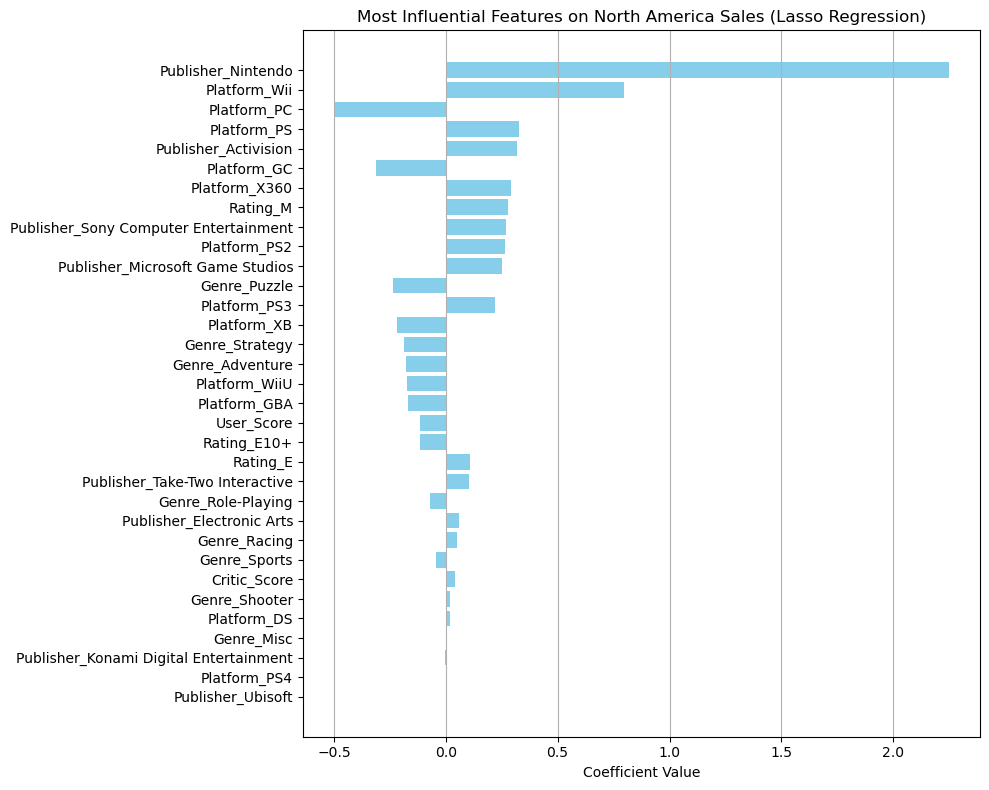

In [ ]:
# 1. Get feature names after transformation
feature_names = coltrans.get_feature_names_out()

# 2. Get the coefficients from the Lasso model
coefficients = lasso_global.coef_

# 3. Combine into a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Filter only important (nonzero) features
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# 5. Sort by absolute value of coefficient (biggest influence first)
important_features = important_features.reindex(important_features['Coefficient'].abs().sort_values(ascending=True).index)

# 6. Plot
plt.figure(figsize=(10, 8))
plt.barh(important_features['Feature'], important_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Most Influential Features on Global Sales (Lasso Regression)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# Most Influential Features in the Global Market

While the prediction scores for the global market weren't great, it seems to represent the common trends from the other countries analyzed, with Nintendo, specifically the Wii, on top.

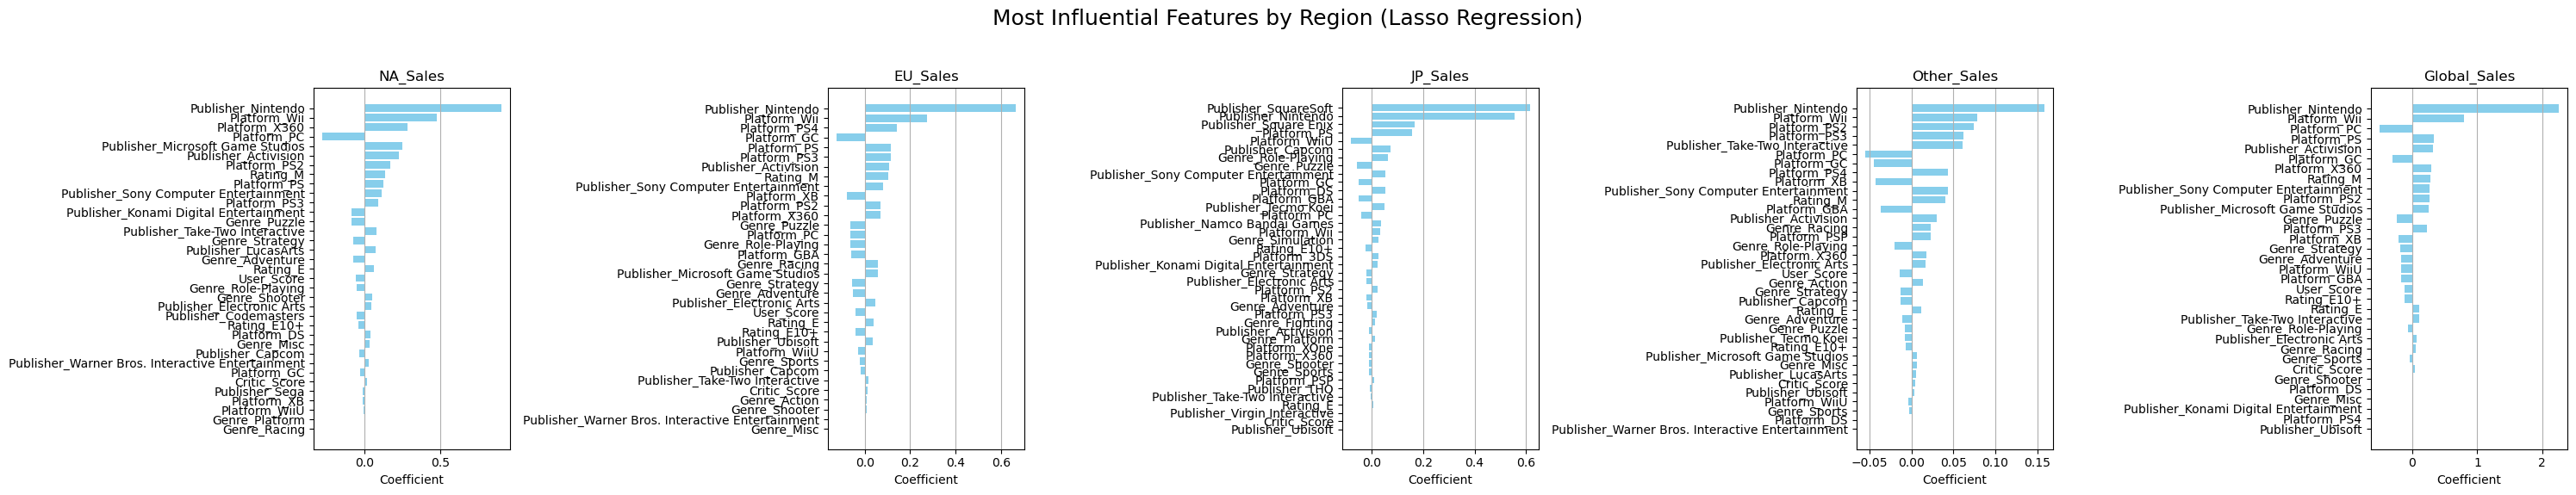

In [ ]:
# All Lasso models
models = {
    'NA_Sales': lasso_na,
    'EU_Sales': lasso_eu,
    'JP_Sales': lasso_jp,
    'Other_Sales': lasso_oth,
    'Global_Sales': lasso_global
}

# Get feature names
feature_names = coltrans.get_feature_names_out()

# Create subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=False)

# Loop through models and plot
for ax, (region, model) in zip(axes, models.items()):
    # Get nonzero coefficients
    coefs = model.coef_
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    })

    # Keep only nonzero coefficients
    importance = importance[importance['Coefficient'] != 0]

    # Sort by absolute value
    importance = importance.reindex(importance['Coefficient'].abs().sort_values().index)

    # Plot
    ax.barh(importance['Feature'], importance['Coefficient'], color='skyblue')
    ax.set_title(region)
    ax.set_xlabel('Coefficient')
    ax.grid(True, axis='x')

plt.suptitle('Most Influential Features by Region (Lasso Regression)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Neural Network Analysis

Out of curiosity, we attempt to use a Neural Network to predict sales for different regions.

In [186]:
# Inputs (already encoded)
X = X_trans

# Multi-output target
y_all = df_mod[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_all, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),  # First hidden layer
    Dense(64, activation='relu'),                               # Second hidden layer
    Dense(5, activation='linear')                               # 5 regression outputs
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean squared error for regression

history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32,
                    verbose=1)


c:\Users\ironi\miniconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.8263 - mae: 0.9098 - val_loss: 1.0060 - val_mae: 0.4051
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8324 - mae: 0.3559 - val_loss: 0.9306 - val_mae: 0.3310
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2823 - mae: 0.3354 - val_loss: 0.9234 - val_mae: 0.3636
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7111 - mae: 0.3810 - val_loss: 0.8895 - val_mae: 0.2864
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4732 - mae: 0.3292 - val_loss: 0.8865 - val_mae: 0.3393
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7688 - mae: 0.3311 - val_loss: 0.8623 - val_mae: 0.3219
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6009 - mae: 0.2906 - val_loss: 0.8638 - val_mae: 0.3771
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7835 - mae: 0.3172 - val_loss: 0.8489 - val_mae: 0.3509
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

In [187]:
# Evaluate overall performance
loss, mae = model.evaluate(X_test, y_test)
print("Test MSE:", loss)
print("Test MAE:", mae)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3766 - mae: 0.2377
Test MSE: 0.5168067812919617
Test MAE: 0.2544175684452057


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


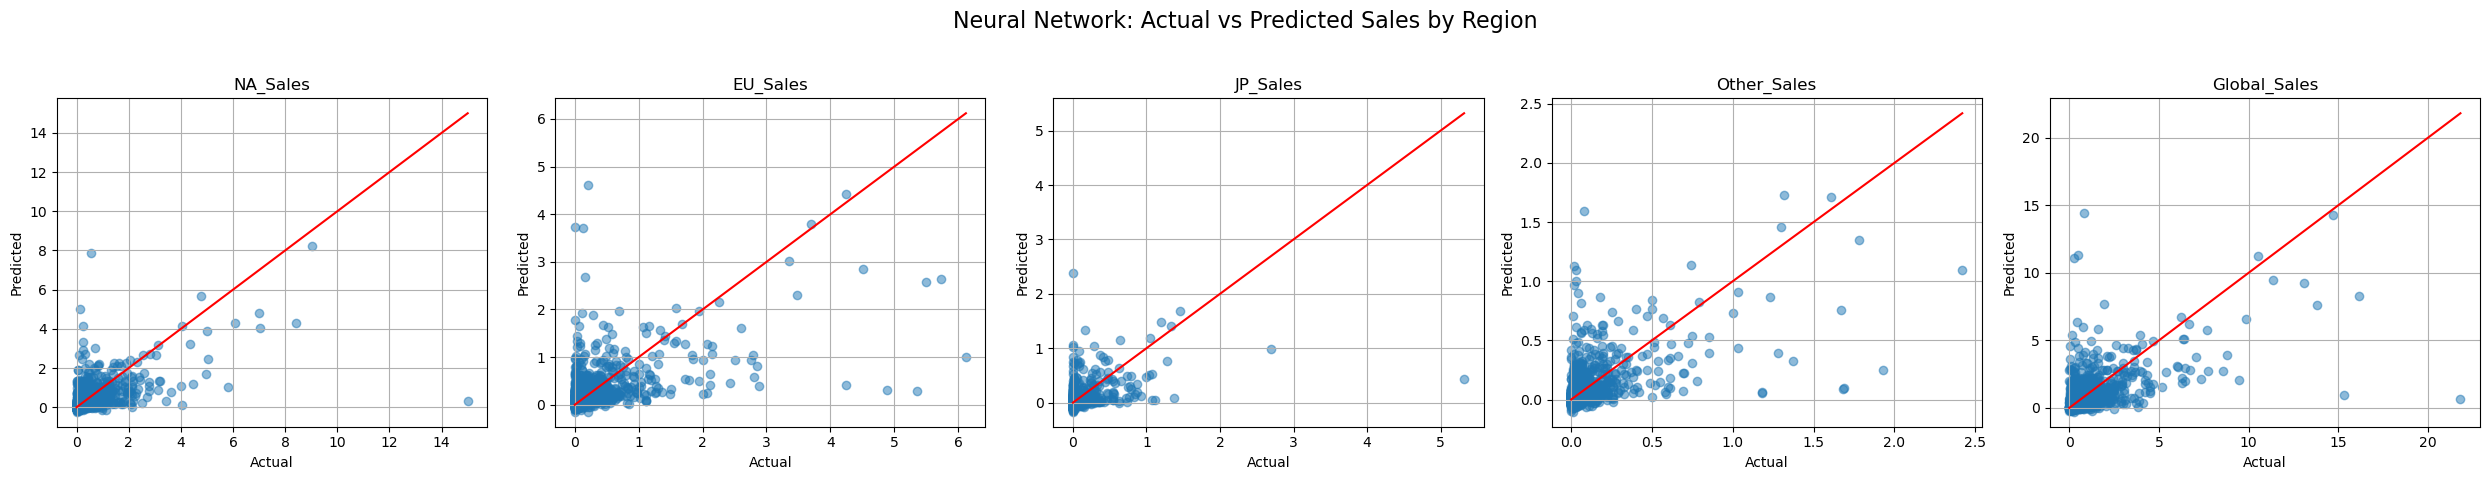

In [191]:
y_pred = model.predict(X_test)

# Titles for each subplot
region_names = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# Create subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Loop through each output dimension
for i in range(5):
    ax = axes[i]
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    ax.plot([0, max(y_test[:, i])], [0, max(y_test[:, i])], 'r')  # identity line
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(region_names[i])
    ax.grid(True)

plt.suptitle("Neural Network: Actual vs Predicted Sales by Region", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Results of Neural Networks

Analyzing the graphs above show us what we were expecting to see: the predictions aren't great. There are some that do better than others, like Japan in comparison to the US, but the difference is minimal.